In [1]:
!pip install Keras
import time
import numpy as np
import pandas as pd
import operator
#import dill as pkl
import pickle as pkl
from matplotlib import pyplot as plt
from collections import defaultdict
#import nltk
#import re
import itertools
#import unittest
#import RegexTester
#from nltk.stem import WordNetLemmatizer
#import nltk
#from nltk.corpus import wordnet
%matplotlib inline
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
#from keras.preprocessing.sequence import pad_sequences
#from keras.utils.np_utils import to_categorical
#from keras.optimizers import SGD

#from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Dropout
from keras.models import Model, load_model, Sequential
#from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers, regularizers, optimizers
#from keras.callbacks import History, CSVLogger
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score, auc

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


/home/sharadv/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# LOAD Pre-processed DATA from Analysis notebook

In [2]:
full_data = pd.read_pickle("./full_data.pkl")
full_data = full_data.reset_index()

# TRAIN/TEST SPLIT

In [3]:
train_set, test_set = train_test_split(full_data, test_size=0.10, random_state=42)

#Separate training set into train and dev. Roughly 80% of original data is train, 10% dev, 10% test
train_set, dev_set = train_test_split(train_set, test_size=0.11, random_state=42)

# Oversampling algorithm - multi-label splitting

In [30]:
def oversample(df, max_records = 10):
    max_per_genre = int(max_records/10)
    new_df = pd.DataFrame(columns=list(df.columns))
    genre_count = defaultdict(int)
    record_count = 0
    while record_count < max_records:
        counter = 0
        sample = df.sample(1, replace = True)
        for i in list(itertools.chain(*sample["list_genres_consol"])):
            if genre_count[i] == max_per_genre:
                df = df[~df["list_genres_consol"].apply(lambda x: str(i) in x)]
                continue
            else:
                counter += 1
        if counter == len(sample["list_genres_consol"]):
            new_df = new_df.append(sample)
            record_count += 1
            for i in list(itertools.chain(*sample["list_genres_consol"])):
                genre_count[i] += 1
    return new_df

In [28]:
train_set = train_set[["flattened_tokens", "list_genres_consol", "binarized_labels"]]

In [31]:
#Generate sample
start = time.time()
sample_df = oversample(train_set, max_records=50000)
end = time.time()
print("Duration in seconds: ", end-start)

KeyboardInterrupt: 

In [40]:
sample_count = defaultdict(int)

def count_genres(row):
    for i in row: 
        sample_count[i]+=1

In [41]:
len(sample_df)

50000

10.00% of the movies are Comedy
10.00% of the movies are Drama
10.00% of the movies are Thriller
10.00% of the movies are Adventure
10.00% of the movies are Sci-Fi
10.00% of the movies are Horror
10.00% of the movies are Family
10.00% of the movies are Action
10.00% of the movies are Crime
10.00% of the movies are Romance


[Text(0,0,'Comedy'),
 Text(0,0,'Drama'),
 Text(0,0,'Thriller'),
 Text(0,0,'Adventure'),
 Text(0,0,'Sci-Fi'),
 Text(0,0,'Horror'),
 Text(0,0,'Family'),
 Text(0,0,'Action'),
 Text(0,0,'Crime'),
 Text(0,0,'Romance')]

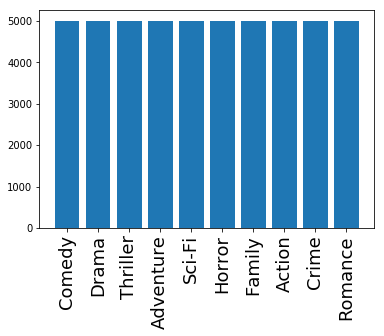

In [42]:
sample_df["list_genres_consol"].apply(lambda row: count_genres(row))

for key,val in sample_count.items():
    print("{:0.2f}% of the movies are {}".format(100*val/len(sample_df), key))



fig, ax = plt.subplots(1,1) 
ax.bar(range(len(sample_count.keys())), list(sample_count.values()))
ax.set_xticks(range(len(sample_count.keys())))
ax.set_xticklabels(list(sample_count.keys()), rotation='vertical', fontsize=18)

# Undersampling

In [43]:
#Distribution of Genres - imbalanced 
count_dict_norm = defaultdict(int)

def dict_count(row, count_dict):
    for genre in row:
        count_dict[genre] += 1

        
count_dict_series = train_set["list_genres_consol"].apply(lambda row: dict_count(row, count_dict_norm))

sorted(count_dict_norm.items(), key=operator.itemgetter(1))

[('Sci-Fi', 11473),
 ('Adventure', 14310),
 ('Crime', 14942),
 ('Horror', 15978),
 ('Family', 16595),
 ('Action', 19939),
 ('Romance', 22628),
 ('Thriller', 22904),
 ('Comedy', 57193),
 ('Drama', 93987)]

In [44]:
def undersample_w_replacement(df, genre_counts):
    """There can be duplicates within genre samples, but not across genre samples"""
    max_records = sorted(genre_counts.items(), key=operator.itemgetter(1))[0][1] #num records for min class
    new_df = pd.DataFrame(columns=list(df.columns))
    for i in list(genre_counts.keys()):
        print(i)
        sample_df = df[df["list_genres_consol"].apply(lambda x: str(i) in x)]
        new_df = new_df.append(sample_df.sample(max_records, replace = True))
        df = df[~df["list_genres_consol"].apply(lambda x: str(i) in x)]
    return new_df.sample(frac=1) #shuffles the sample dataframe

def undersample_w_out_replacement(df, genre_counts):
    """There can be duplicates across genre samples, but not within genre samples"""
    max_records = sorted(genre_counts.items(), key=operator.itemgetter(1))[0][1] #num records for min class
    new_df = pd.DataFrame(columns=list(df.columns))
    for i in list(genre_counts.keys()):
        print(i)
        sample_df = df[df["list_genres_consol"].apply(lambda x: str(i) in x)]
        new_df = new_df.append(sample_df.sample(max_records, replace = False))
    return new_df.sample(frac=1) #shuffles the sample dataframe

In [45]:
start = time.time()
sample_df = undersample_w_out_replacement(train_set, count_dict_norm)
end = time.time()
print("total time: ", end-start, "seconds")

Drama
Action
Romance
Horror
Comedy
Sci-Fi
Family
Adventure
Thriller
Crime
total time:  6.428191661834717 seconds


In [46]:
#Sample without replacement - more balanced
count_dict_undersample_w_out_replacement = defaultdict(int)
count_val_series_2 = sample_df["list_genres_consol"].apply(lambda row: dict_count(row, count_dict_undersample_w_out_replacement))
count_dict_undersample_w_out_replacement

defaultdict(int,
            {'Adventure': 21593,
             'Drama': 49207,
             'Comedy': 33091,
             'Sci-Fi': 19394,
             'Family': 17495,
             'Action': 27972,
             'Crime': 20436,
             'Horror': 19118,
             'Thriller': 27672,
             'Romance': 21061})

[Text(0,0,'Adventure'),
 Text(0,0,'Drama'),
 Text(0,0,'Comedy'),
 Text(0,0,'Sci-Fi'),
 Text(0,0,'Family'),
 Text(0,0,'Action'),
 Text(0,0,'Crime'),
 Text(0,0,'Horror'),
 Text(0,0,'Thriller'),
 Text(0,0,'Romance')]

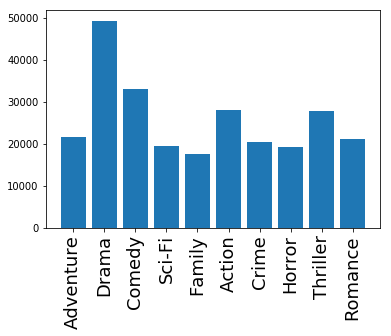

In [47]:
fig, ax = plt.subplots(1,1) 
ax.bar(range(len(count_dict_undersample_w_out_replacement.keys())), list(count_dict_undersample_w_out_replacement.values()))
ax.set_xticks(range(len(count_dict_undersample_w_out_replacement.keys())))
ax.set_xticklabels(list(count_dict_undersample_w_out_replacement.keys()), rotation='vertical', fontsize=18)

In [55]:
#Sample with replacement - even more balanced but less variance within genres 
start = time.time()
sample_df = undersample_w_replacement(train_set, count_dict_norm)
end = time.time()
print("total time: ", end-start, "seconds")

Drama
Action
Romance
Horror
Comedy
Sci-Fi
Family
Adventure
Thriller
Crime
total time:  4.863096714019775 seconds


In [56]:
count_dict_undersample_w_replacement = defaultdict(int)
count_val_series_2 = sample_df["list_genres_consol"].apply(lambda row: dict_count(row, count_dict_undersample_w_replacement))
count_dict_undersample_w_replacement

defaultdict(int,
            {'Drama': 11473,
             'Action': 12356,
             'Sci-Fi': 16186,
             'Comedy': 24595,
             'Horror': 13303,
             'Romance': 14044,
             'Thriller': 20722,
             'Adventure': 19631,
             'Crime': 17512,
             'Family': 15525})

[Text(0,0,'Drama'),
 Text(0,0,'Action'),
 Text(0,0,'Sci-Fi'),
 Text(0,0,'Comedy'),
 Text(0,0,'Horror'),
 Text(0,0,'Romance'),
 Text(0,0,'Thriller'),
 Text(0,0,'Adventure'),
 Text(0,0,'Crime'),
 Text(0,0,'Family')]

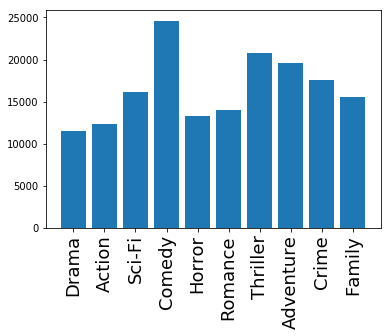

In [57]:
fig, ax = plt.subplots(1,1) 
ax.bar(range(len(count_dict_undersample_w_replacement.keys())), list(count_dict_undersample_w_replacement.values()))
ax.set_xticks(range(len(count_dict_undersample_w_replacement.keys())))
ax.set_xticklabels(list(count_dict_undersample_w_replacement.keys()), rotation='vertical', fontsize=18)

# BoW TFIDF

In [4]:
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(full_data["list_genres_consol"])

MAX_NB_WORDS = 80000
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train_set['flattened_tokens'])

# tokenizer.fit_on_texts(sample_df['flattened_tokens'])

In [54]:
# x_train_bow = tokenizer.texts_to_matrix(train_set["flattened_tokens"], mode="tfidf")
# print(x_train_bow.shape)
# x_dev_bow = tokenizer.texts_to_matrix(dev_set["flattened_tokens"], mode="tfidf")
# print(x_dev_bow.shape)
# x_test_bow = tokenizer.texts_to_matrix(test_set["flattened_tokens"], mode = "tfidf")
# print(x_test_bow.shape)

#---Sample Data----
x_train_bow = tokenizer.texts_to_matrix(sample_df["flattened_tokens"], mode="tfidf")
print(x_train_bow.shape)
x_dev_bow = tokenizer.texts_to_matrix(dev_set["flattened_tokens"], mode="tfidf")
print(x_dev_bow.shape)
x_test_bow = tokenizer.texts_to_matrix(test_set["flattened_tokens"], mode = "tfidf")
print(x_test_bow.shape)

(114730, 80000)
(22206, 80000)
(22431, 80000)


In [55]:
#BoW TFIDF 
model = Sequential()
model.add(Dense(50, input_shape=(x_train_bow.shape[1],), activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(mlb.classes_.shape[0], activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ["accuracy"])

In [56]:
#Fit model

#----Single Dataset to fit----
model.fit(x_train_bow, np.stack(sample_df["binarized_labels"]), epochs = 10, batch_size = 10000)
# model.fit(x_train_bow, np.stack(train_set["binarized_labels"]), epochs = 10, batch_size = 10000)

#----Multiple Datasets (Over/UnderSampling)---


Epoch 1/10
114730/114730 [==============================] - 106s 923us/step - loss: 0.4832 - acc: 0.7953
Epoch 2/10
114730/114730 [==============================] - 86s 754us/step - loss: 0.3541 - acc: 0.8672
Epoch 3/10
114730/114730 [==============================] - 85s 740us/step - loss: 0.3063 - acc: 0.8873
Epoch 4/10
114730/114730 [==============================] - 86s 749us/step - loss: 0.2750 - acc: 0.9011
Epoch 5/10
114730/114730 [==============================] - 85s 744us/step - loss: 0.2522 - acc: 0.9117
Epoch 6/10
114730/114730 [==============================] - 87s 760us/step - loss: 0.2337 - acc: 0.9197
Epoch 7/10
114730/114730 [==============================] - 86s 751us/step - loss: 0.2187 - acc: 0.9265
Epoch 8/10
114730/114730 [==============================] - 87s 756us/step - loss: 0.2057 - acc: 0.9315
Epoch 9/10
114730/114730 [==============================] - 86s 746us/step - loss: 0.1940 - acc: 0.9364
Epoch 10/10
114730/114730 [==============================] - 86

In [57]:
preds = model.predict(x_dev_bow)

In [58]:
from keras.models import load_model
model.save("BOW_tfidf_50dim_10kbatch_dropout_undersample_w_replace.h5")

# EVAL METRICS

In [23]:
#Load previously stored models if desired

model = load_model('BOW_tfidf_75dim_1kbatch.h5')
preds = model.predict(x_dev_bow)

In [32]:
def indiv_class_scores(y_true, y_pred, threshold, metric = None):
    max_pred = np.array(y_pred.max(axis = 1)).reshape(-1,1)
    
    #Cant predict 0 for all classes - pick max val as label if all preds below threshold
    for i in range(len(max_pred)): 
        if max_pred[i] > threshold:
            max_pred[i] = threshold
        else:
            pass
        
    y_pred = y_pred >= max_pred
    
    for i in range(len(mlb.classes_)):
        if metric == "precision":
            score = precision_score(y_true[:,i], y_pred[:,i])
            print("The {} for {} is {}".format(metric, mlb.classes_[i], score))
        elif metric == "recall":
            score = recall_score(y_true[:,i], y_pred[:,i])
            print("The {} for {} is {}".format(metric, mlb.classes_[i], score))
        elif metric == "f1":
            score = f1_score(y_true[:,i], y_pred[:,i])
            print("The {} for {} is {}".format(metric, mlb.classes_[i], score))
        else:
            return "Not a valid metric"

In [59]:
indiv_class_scores(np.stack(dev_set["binarized_labels"]), preds, threshold = 0.5, metric = "precision")
indiv_class_scores(np.stack(dev_set["binarized_labels"]), preds, threshold=0.5, metric = "recall")
indiv_class_scores(np.stack(dev_set["binarized_labels"]), preds, threshold= 0.5, metric= "f1")

The precision for Action is 0.6032818532818532
The precision for Adventure is 0.3867435158501441
The precision for Comedy is 0.6186666666666667
The precision for Crime is 0.42150395778364114
The precision for Drama is 0.8551601423487545
The precision for Family is 0.3847139197267293
The precision for Horror is 0.6214046822742475
The precision for Romance is 0.40328563857975624
The precision for Sci-Fi is 0.574265289912629
The precision for Thriller is 0.3356246264196055
The recall for Action is 0.2513067953357459
The recall for Adventure is 0.3731924360400445
The recall for Comedy is 0.6235676899137077
The recall for Crime is 0.3428111587982833
The recall for Drama is 0.20844899375433726
The recall for Family is 0.42986641221374045
The recall for Horror is 0.4706180344478217
The recall for Romance is 0.2791636096845194
The recall for Sci-Fi is 0.48818365968939903
The recall for Thriller is 0.3978037548707049
The f1 for Action is 0.35481124042009654
The f1 for Adventure is 0.37984715539

In [60]:
y_pred = preds >= 0.5
micro_precision = precision_score(np.stack(dev_set["binarized_labels"]), y_pred, average = 'micro')
weighted_macro_precision = precision_score(np.stack(dev_set["binarized_labels"]), y_pred, average = 'weighted')
micro_recall = recall_score(np.stack(dev_set["binarized_labels"]), y_pred, average = 'micro')
weighted_macro_recall = recall_score(np.stack(dev_set["binarized_labels"]), y_pred, average = 'weighted')
micro_f1 = f1_score(np.stack(dev_set["binarized_labels"]), y_pred, average = 'micro')
weighted_macro_f1 = f1_score(np.stack(dev_set["binarized_labels"]), y_pred, average = 'weighted')
print("The micro precision is", micro_precision)
print("The weighted macro precision is", weighted_macro_precision)
print("The micro recall is", micro_recall)
print("The weighted macro recall is", weighted_macro_recall)
print("The micro f1 is", micro_f1)
print("The weighted macro f1 is", weighted_macro_f1)


The micro precision is 0.6168607632022266
The weighted macro precision is 0.6885585135095638
The micro recall is 0.23494950622105673
The weighted macro recall is 0.23494950622105673
The micro f1 is 0.3402897028222792
The weighted macro f1 is 0.3123432564327975


In [33]:
def auc_pr(y_true, y_pred):
    scores = []
    for i in range(len(mlb.classes_)):
        p, r, d = precision_recall_curve(y_true[:,i], y_pred[:,i])
        score = auc(r,p)
        scores.append(score)
        print("The AUC for {} is {}".format(mlb.classes_[i], score))
    macro_score = np.mean(scores)
    y_true_raveled = np.ravel(y_true)
    y_pred_raveled = np.ravel(y_pred)
    p, r, d = precision_recall_curve(y_true_raveled, y_pred_raveled)
    micro_score = auc(r,p)
    print("The micro-avg AUC is {}".format(micro_score))
    print("The macro-avg AUC is {}".format(macro_score))



In [61]:
auc_pr(np.stack(dev_set["binarized_labels"]), preds)

The AUC for Action is 0.4696243611021378
The AUC for Adventure is 0.3710614922066198
The AUC for Comedy is 0.674724504811205
The AUC for Crime is 0.37310093060426786
The AUC for Drama is 0.7254241229009942
The AUC for Family is 0.4170249457169868
The AUC for Horror is 0.5770437674191291
The AUC for Romance is 0.31974960745007497
The AUC for Sci-Fi is 0.5413224444601781
The AUC for Thriller is 0.329758385514635
The micro-avg AUC is 0.48519439162806854
The macro-avg AUC is 0.47988345621862294


# BOW-Neural sum of embeddings

## Load Word Embeddings

In [3]:
def loadEmbed(file):
    start = time.time()
    print("Loading Embeddings")
    f = open(file, 'r', encoding='utf-8')
    model = {}
    status_every = 100000
    for i, line in enumerate(f):
        if i%status_every == 0:
            print('Processing line {:,}'.format(i))
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.",'{:,}'.format(len(model))," words loaded!")
    end = time.time()
    print("Total Time to load embeddings:", end - start, "seconds")
    return model

In [4]:
#TOO LARGE TO PUSH TO GIT, DOWNLOAD SEPARATLEY FROM https://github.com/stanfordnlp/GloVe
glove_dir = './glove.6B/'
glove_filename = 'glove.6B.300d.txt'
glove_fullpath = glove_dir + glove_filename
glove_dd = loadEmbed(glove_fullpath)

Loading Embeddings
Processing line 0
Processing line 100,000
Processing line 200,000
Processing line 300,000
Processing line 400,000
Done. 400,001  words loaded!
Total Time to load embeddings: 40.277053356170654 seconds


In [20]:
#For unknown values
average_vec = np.mean(np.array(list(glove_dd.values())), axis = 0)

# Read Full Data and Generate Embeddings for BOW

In [5]:
full_data["plot_lengths"] = full_data["flattened_tokens"].apply(lambda row: len(row))

62.0


(array([6.0170e+03, 9.1429e+04, 6.5346e+04, 3.5824e+04, 1.8519e+04,
        6.5880e+03, 4.9200e+02, 4.5000e+01, 3.5000e+01, 8.0000e+00]),
 array([  4. ,  22.4,  40.8,  59.2,  77.6,  96. , 114.4, 132.8, 151.2,
        169.6, 188. ]),
 <a list of 10 Patch objects>)

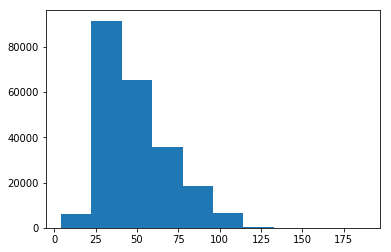

In [6]:
print(np.percentile(full_data["plot_lengths"],75))
plt.hist(full_data["plot_lengths"])

In [7]:
len(full_data)

224303

In [22]:
def embed_plot_BOW(plot):
    word_embeddings = np.array([glove_dd.get(word, average_vec) for word in plot]).astype(np.float32)
    sentence_embedding = [sum(dim) for dim in zip(*word_embeddings)]
    return np.array(sentence_embedding)

In [23]:
print("Embedding plots...")
start = time.time()
full_data["flattened_embeddings"] = full_data["flattened_tokens"].apply(lambda row: embed_plot_BOW(row))
end = time.time()
print("Total Time to embed plots:", end - start, "seconds")

Embedding plots...
Total Time to embed plots: 702.6706018447876 seconds


In [ ]:
#full_data.to_pickle("./full_data_w_flattened_embeddings.pkl")

In [ ]:
#full_data = pd.read_pickle("./full_data_w_flattened_embeddings.pkl")

In [ ]:
full_data_sample = full_data.iloc[0:2] #sample to start with

In [24]:
train_set, test_set = train_test_split(full_data, test_size=0.10, random_state=42)

#Separate training set into train and dev. Roughly 80% of original data is train, 10% dev, 10% test
train_set, dev_set = train_test_split(train_set, test_size=0.11, random_state=42)

mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(full_data["list_genres_consol"])

In [58]:
# x_train_bow_embed = np.stack(train_set["flattened_embeddings"])
# x_dev_bow_embed = np.stack(dev_set["flattened_embeddings"])
# x_test_bow_embed = np.stack(test_set["flattened_embeddings"])

#----Sampled Data---
x_train_bow_embed = np.stack(sample_df["flattened_embeddings"])
#y_train = np.stack(y_train.values)
x_dev_bow_embed = np.stack(dev_set["flattened_embeddings"])
#y_test = np.stack(y_test.values)
x_test_bow_embed = np.stack(test_set["flattened_embeddings"])


In [59]:
print(x_train_bow_embed.shape)
print(x_dev_bow_embed.shape)
print(x_test_bow_embed.shape)

(114730, 300)
(22206, 300)
(22431, 300)


# MODEL

In [60]:
model_bow_embed = Sequential()
model_bow_embed.add(Dense(100, input_shape=(x_train_bow_embed.shape[1],), activation='tanh'))
model_bow_embed.add(Dropout(0.5))
model_bow_embed.add(Dense(mlb.classes_.shape[0], activation='sigmoid'))
model_bow_embed.compile(loss='binary_crossentropy', optimizer='adam', metrics = ["accuracy"])


In [61]:
# model_bow_embed.fit(x_train_bow_embed, np.stack(train_set["binarized_labels"]), epochs = 10, batch_size = 1000)
model_bow_embed.fit(x_train_bow_embed, np.stack(sample_df["binarized_labels"]), epochs = 10, batch_size = 1000)

Epoch 1/10
114730/114730 [==============================] - 2s 19us/step - loss: 0.4492 - acc: 0.8265
Epoch 2/10
114730/114730 [==============================] - 1s 10us/step - loss: 0.3671 - acc: 0.8541
Epoch 3/10
114730/114730 [==============================] - 1s 10us/step - loss: 0.3423 - acc: 0.8624
Epoch 4/10
114730/114730 [==============================] - 1s 10us/step - loss: 0.3302 - acc: 0.8671
Epoch 5/10
114730/114730 [==============================] - 1s 10us/step - loss: 0.3228 - acc: 0.8696
Epoch 6/10
114730/114730 [==============================] - 1s 10us/step - loss: 0.3187 - acc: 0.8712
Epoch 7/10
114730/114730 [==============================] - 1s 10us/step - loss: 0.3160 - acc: 0.8723
Epoch 8/10
114730/114730 [==============================] - 1s 10us/step - loss: 0.3139 - acc: 0.8730
Epoch 9/10
114730/114730 [==============================] - 1s 10us/step - loss: 0.3123 - acc: 0.8738
Epoch 10/10
114730/114730 [==============================] - 1s 10us/step - loss: 

In [63]:
preds_bow_embed = model_bow_embed.predict(x_dev_bow_embed)

In [64]:
from keras.models import load_model
model_bow_embed.save("BOW_embed_100dim_1kbatch_dropout_undersample_w_replace.h5")

In [65]:
indiv_class_scores(np.stack(dev_set["binarized_labels"]), preds_bow_embed, threshold = 0.5, metric = "precision")
indiv_class_scores(np.stack(dev_set["binarized_labels"]), preds_bow_embed, threshold=0.5, metric = "recall")
indiv_class_scores(np.stack(dev_set["binarized_labels"]), preds_bow_embed, threshold= 0.5, metric= "f1")

y_pred = preds_bow_embed >= 0.5
micro_precision = precision_score(np.stack(dev_set["binarized_labels"]), y_pred, average = 'micro')
weighted_macro_precision = precision_score(np.stack(dev_set["binarized_labels"]), y_pred, average = 'weighted')
micro_recall = recall_score(np.stack(dev_set["binarized_labels"]), y_pred, average = 'micro')
weighted_macro_recall = recall_score(np.stack(dev_set["binarized_labels"]), y_pred, average = 'weighted')
micro_f1 = f1_score(np.stack(dev_set["binarized_labels"]), y_pred, average = 'micro')
weighted_macro_f1 = f1_score(np.stack(dev_set["binarized_labels"]), y_pred, average = 'weighted')
print("The micro precision is", micro_precision)
print("The weighted macro precision is", weighted_macro_precision)
print("The micro recall is", micro_recall)
print("The weighted macro recall is", weighted_macro_recall)
print("The micro f1 is", micro_f1)
print("The weighted macro f1 is", weighted_macro_f1)

auc_pr(np.stack(dev_set["binarized_labels"]), preds_bow_embed)


The precision for Action is 0.6363636363636364
The precision for Adventure is 0.3517823639774859
The precision for Comedy is 0.5891117478510028
The precision for Crime is 0.36946386946386944
The precision for Drama is 0.8955094991364422
The precision for Family is 0.3481418197351559
The precision for Horror is 0.5847808105872622
The precision for Romance is 0.3748898678414097
The precision for Sci-Fi is 0.4993638676844784
The precision for Thriller is 0.34317032040472173
The recall for Action is 0.18576598311218334
The recall for Adventure is 0.41713014460511677
The recall for Comedy is 0.5816947234403734
The recall for Crime is 0.5101931330472103
The recall for Drama is 0.08995489243580847
The recall for Family is 0.38883587786259544
The recall for Horror is 0.35815602836879434
The recall for Romance is 0.31217901687454147
The recall for Sci-Fi is 0.5300472653612424
The recall for Thriller is 0.2883457314913213
The f1 for Action is 0.2875816993464052
The f1 for Adventure is 0.38167938

# BI_DIRECTIONAL LSTM -- IGNORE EVERYTHING BELOW

In [ ]:
embedding_matrix = np.load("embed_matrix.npy")

In [ ]:
MAX_NB_WORDS = 80000
EMBEDDING_DIM = 100
MAX_SENT_LENGTH = 15
REG_PARAM = 1e-13
l2_reg = regularizers.l2(REG_PARAM)

embedding_layer = Embedding(MAX_NB_WORDS + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=75,
                            embeddings_regularizer=l2_reg,
                            mask_zero = True, #determines whether masking is performed, i.e. whether the layers ignore the padded zeros in shorter documents
                            trainable=False) 

tokenizer = Tokenizer(num_words=MAX_NB_WORDS+1, oov_token='UNK')
tokenizer.fit_on_texts(full_data['flattened_tokens'])

In [ ]:
MAX_SENTS = 5
data = np.zeros((len(full_data), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')
doc_lst = []

# keep the MAX_NB_WORDS most frequent words and replace the rest with 'UNK'
# truncate to the first MAX_SENTS sentences per doc and MAX_SENT_LENGTH words per sentence

for summary_num, row in full_data.iterrows():
    for sent_num, sent in enumerate(row['tokenized_words']):
        if sent_num < MAX_SENTS:
            #wordTokens = text_to_word_sequence(sent)
            word_num = 0
            words_in_sent = []
            for _, word in enumerate(sent):
                if word_num < MAX_SENT_LENGTH: 
                    if (word in tokenizer.word_index) and (tokenizer.word_index[word] <= MAX_NB_WORDS):
                        data[summary_num, sent_num, word_num] = tokenizer.word_index[word]
                        words_in_sent.append(word)
                    else:
                        data[summary_num, sent_num, word_num] = MAX_NB_WORDS
                        words_in_sent.append('UNK')
                    word_num = word_num + 1
            doc_lst.append(words_in_sent)

In [ ]:
lstm_plot_data = data.reshape(len(full_data), -1) #collapse sentence length and max sents into single dimension
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(lstm_plot_data, 
                                                    full_data["binarized_labels"], test_size=0.20, random_state=42)

# X_train_lstm = np.stack(X_train_lstm.values)
y_train_lstm = np.stack(y_train_lstm.values)
# X_test_lstm = np.stack(X_test_lstm.values)
y_test_lstm = np.stack(y_test_lstm.values)

In [ ]:
input_layer = Input(shape=(X_train_lstm.shape[1],), dtype='int32')
embedded_plot = embedding_layer(input_layer)
bilstm_layer = Bidirectional(LSTM(100))(embedded_plot)
output_layer = Dense(units=mlb.classes_.shape[0], activation="sigmoid")(bilstm_layer)
LSTM_model = Model(inputs=input_layer, outputs= output_layer)
LSTM_model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ["accuracy"])
LSTM_model.fit(X_train_lstm, y_train_lstm, epochs = 1, batch_size = 100)
preds_LSTM = LSTM_model.predict(X_test_lstm)

In [ ]:
indiv_class_scores(y_test_lstm, preds_LSTM, threshold = 0.5, metric = "precision")

In [ ]:
indiv_class_scores(y_test_lstm, preds_LSTM, threshold = 0.5, metric = "recall")

In [ ]:
indiv_class_scores(y_test_lstm, preds_LSTM, threshold = 0.5, metric = "f1")

In [ ]:
y_pred_LSTM = preds_LSTM >= 0.5
micro_precision = precision_score(y_test_lstm, y_pred_LSTM, average = 'micro')
weighted_macro_precision = precision_score(y_test_lstm, y_pred_LSTM, average = 'weighted')
micro_recall = recall_score(y_test_lstm, y_pred_LSTM, average = 'micro')
weighted_macro_recall = recall_score(y_test_lstm, y_pred_LSTM, average = 'weighted')
micro_f1 = f1_score(y_test_lstm, y_pred_LSTM, average = 'micro')
weighted_macro_f1 = f1_score(y_test_lstm, y_pred_LSTM, average = 'weighted')

In [ ]:
print("The micro precision is", micro_precision)
print("The weighted macro precision is", weighted_macro_precision)
print("The micro recall is", micro_recall)
print("The weighted macro recall is", weighted_macro_recall)
print("The micro f1 is", micro_f1)
print("The weighted macro f1 is", weighted_macro_f1)